# VIN Exploration

## Load Data

In [20]:
import pandas as pd
from utils.vin_validator import VIN, is_valid_vin

%matplotlib inline

In [21]:
url = 'https://s3-us-west-2.amazonaws.com/pcadsassessment/parking_citations.corrupted.csv'
df = pd.read_csv(url)

df_no_make = df[df['Make'].isna()]
df_with_make = df[~df['Make'].isna()]

/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
df[~df['VIN'].isnull()]['VIN'].head(12)

1235876    1ZVFT80N465228314
1235877                 0199
1235878                 3491
1235879    1G1ZS58F47F170546
1235880                 9817
1235881                 0739
1235882                 3204
1235883          NOT VISIBLE
1235884          NOT VISIBLE
1235885                 0003
1235886                 6106
1235887                 2865
Name: VIN, dtype: object

In [23]:
vin = VIN('1ZVFT')


In [24]:
vin.region_code
vin.does_vehicle_year_use_1980_range
vin.vehicle_year


In [25]:
df_with_makes = df[~df['Make'].isnull()]
#
df[~df['VIN'].isnull()].shape[0]

16309

In [26]:
df_with_makes['VIN'].str.slice(stop=3)



4          NaN
6          NaN
10         NaN
11         NaN
14         NaN
          ... 
8726006    NaN
8726008    NaN
8726010    NaN
8726011    NaN
8726013    NaN
Name: VIN, Length: 4357544, dtype: object

In [27]:
df['VIN'].value_counts()



NOT VISIBLE    1894
COVERED         769
NV              509
3283              8
2404              8
               ... 
2446              1
5472              1
2642              1
5429              1
6872              1
Name: VIN, Length: 7745, dtype: int64

## Can VINs be trusted to be accurately recorded?
Should I treat manufacturer matches here with complete certainty or is it still better to throw into the model and let it decide?
A good enough model should be able to use thisinfo, but not certain.



## VIN Exploration

### Are there duplicated VINs?
Notes:
 - If cache should be created to first check known vehicle makes

In [28]:
num_records_per_vin = df['VIN'].value_counts()
num_records_per_vin.describe()

count    7745.000000
mean        2.105746
std        23.925009
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max      1894.000000
Name: VIN, dtype: float64

In [29]:
num_records_per_vin[num_records_per_vin>1]

NOT VISIBLE    1894
COVERED         769
NV              509
3283              8
2404              8
               ... 
9857              2
0073              2
0511              2
3593              2
5828              2
Name: VIN, Length: 3475, dtype: int64

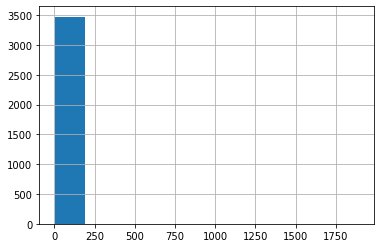

In [30]:
num_records_per_vin[num_records_per_vin>1].hist()

#### Get Corrupted VINS
Notes:
 - Minimum VIN length
 - Invalid characteres
 - Null values

In [31]:
nan_vins = ['NOT VISIBLE', 'COVERED', 'NV', 'nan']
get_df_null_vins = lambda df: df[df['VIN'].isin(nan_vins) | df['VIN'].isnull() | df['VIN'].isna()]

In [33]:
df_with_make_and_null_vin = get_df_null_vins(df_with_make)
df_with_make_and_non_null_vin = df_with_make[~df_with_make.index.isin(df_with_make_and_null_vin.index)]
df['is_valid_vin'] = df['VIN'].dropna().apply(is_valid_vin)
df_with_make_and_non_null_vin['is_valid_vin'] = df_with_make_and_non_null_vin['VIN'].apply(is_valid_vin)
df_with_make_and_valid_vin = df_with_make_and_non_null_vin[df_with_make_and_non_null_vin['is_valid_vin'] == True]

/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/ipykernel_launcher.py:546: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [34]:
num_records_per_valid_vin = df_with_make_and_valid_vin[df_with_make_and_valid_vin['is_valid_vin'] == True]['VIN'].value_counts()
duplicated_vins = num_records_per_valid_vin[num_records_per_valid_vin>1].keys().tolist()
num_records_per_make_and_valid_vin = df_with_make_and_valid_vin[df_with_make_and_valid_vin['is_valid_vin'] == True]['VIN'].value_counts()
num_records_per_valid_vin[num_records_per_valid_vin>1]

WDDHF5KB3EA888988    3
1GKEC13V64R246017    2
1GKEK13Z54R135299    2
1GCHC23668F199523    2
JF2SJAAC6EH543691    2
19VDE1F38FE001979    2
WBA3C1C51EK114535    2
Name: VIN, dtype: int64

#### Are the duplicated VINs with makes consistent?

In [35]:
df_with_make_and_valid_vin[df_with_make_and_valid_vin['VIN'].isin(duplicated_vins)].sort_values(by=['VIN', 'Make'])[['VIN', 'Make']]

VIN  Make
1245376  19VDE1F38FE001979  ACUR
1250867  19VDE1F38FE001979  ACUR
1250183  1GCHC23668F199523  CHEV
1250184  1GCHC23668F199523  CHEV
1250195  1GKEC13V64R246017   GMC
1250196  1GKEC13V64R246017   GMC
1237765  1GKEK13Z54R135299   GMC
1237766  1GKEK13Z54R135299   GMC
1246464  JF2SJAAC6EH543691  SUBA
1246465  JF2SJAAC6EH543691  SUBA
1239786  WBA3C1C51EK114535   BMW
1239787  WBA3C1C51EK114535   BMW
1240288  WDDHF5KB3EA888988  MERZ
1240289  WDDHF5KB3EA888988  MERZ
1240378  WDDHF5KB3EA888988  MERZ

In [36]:
s_is_vin_make_consistent =df_with_make_and_valid_vin.groupby('VIN')['Make'].apply(lambda s_makes: len(set(s_makes)) == 1)
s_is_vin_make_consistent.all()

True

#### Get the make for each known VIN

In [37]:
s_known_vin_makes = df_with_make_and_valid_vin.groupby('VIN')['Make'].apply(lambda s_makes: s_makes.iloc[0])
s_known_vin_makes

VIN
19UUA56643A034580    ACUR
19UUA66228A003385    ACUR
19UUA66235A048671    ACUR
19UUA66255A008477    FORD
19UUA8F26AA025312    ACUR
                     ... 
YV1622FSXC2118620    VOLV
YV1AX8851K1841623    VOLV
YV1TS592261445328    VOLV
ZAM57RTA1E1103659    MASE
ZAM57RTA8E1091462    MASE
Name: Make, Length: 375, dtype: object

In [39]:
import json
with open('../data/known_vins.json', 'w') as outfile:
    json.dump(s_known_vin_makes.to_dict(), outfile)

In [ ]:
known_vins = s_known_vin_makes.keys().tolist()
df_with_make[df_with_make['VIN'].isin(known_vins)]['VIN'].value_counts().head()

In [ ]:
df_false_corruptions = df_no_make[df_no_make['VIN'].isin(known_vins)]
df_false_corruptions.shape[0]

In [ ]:
df_false_corruptions[['VIN', 'Make']]

In [ ]:
df_false_corruptions = df_false_corruptions.merge(s_known_vin_makes, left_on='VIN', right_index=True, suffixes=('', '_known'))
df_false_corruptions[['VIN', 'Make', 'Make_known']]


### Extract VIN Information

Notes:
 - Even the non-fully completed VINS may have information about the vehicle  
 - Digit Info:
    - 1-3: WIN (World Identification Number)
        - First 2 can be used to parse where manufacturer located
    - 4-9: Vehicle Attributes
    - 10: Model Year
    - 11: Plant Code



Relatively small % of citations with VINs.. Don't get carried away